# Singular Values Visualization for Dual Training Experiment

This notebook visualizes the singular values of weight matrices from the dual training experiment comparing Shampoo and Muon optimizers.

## Data Structure
- **Log Directory**: `logs/dual_training_<uuid>/`
- **Singular Values**: `singular_values_shampoo.pkl` and `singular_values_muon.pkl`
- **Metrics**: `metrics_shampoo.npy` and `metrics_muon.npy`
- **Config**: `config.pt`

Each pickle file contains a list of tuples: `(step, sv_dict)` where:
- `step`: training step number
- `sv_dict`: dictionary mapping parameter names to their singular values (numpy arrays)


In [2]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from pathlib import Path
import glob
from typing import Dict, List, Tuple
import pandas as pd

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Increase figure size and font size
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10


## Load Data


In [4]:
def find_latest_experiment():
    """Find the most recent dual training experiment."""
    logs_dir = Path('logs')
    if not logs_dir.exists():
        raise FileNotFoundError("No logs directory found. Please run the dual training experiment first.")
    
    # Find all dual training directories
    dual_dirs = list(logs_dir.glob('dual_training_*'))
    if not dual_dirs:
        raise FileNotFoundError("No dual training experiments found in logs directory.")
    
    # Return the most recent one
    latest_dir = max(dual_dirs, key=lambda x: x.stat().st_mtime)
    print(f"Using experiment directory: {latest_dir}")
    return latest_dir

def load_experiment_data(exp_dir: Path):
    """Load all data from an experiment directory."""
    data = {}
    
    # Load singular values
    shampoo_sv_path = exp_dir / 'singular_values_shampoo.pkl'
    muon_sv_path = exp_dir / 'singular_values_muon.pkl'
    
    if shampoo_sv_path.exists():
        with open(shampoo_sv_path, 'rb') as f:
            data['singular_values_shampoo'] = pickle.load(f)
    else:
        print(f"Warning: {shampoo_sv_path} not found")
    
    if muon_sv_path.exists():
        with open(muon_sv_path, 'rb') as f:
            data['singular_values_muon'] = pickle.load(f)
    else:
        print(f"Warning: {muon_sv_path} not found")
    
    # Load metrics
    shampoo_metrics_path = exp_dir / 'metrics_shampoo.npy'
    muon_metrics_path = exp_dir / 'metrics_muon.npy'
    
    if shampoo_metrics_path.exists():
        data['metrics_shampoo'] = np.load(shampoo_metrics_path, allow_pickle=True)
    else:
        print(f"Warning: {shampoo_metrics_path} not found")
    
    if muon_metrics_path.exists():
        data['metrics_muon'] = np.load(muon_metrics_path, allow_pickle=True)
    else:
        print(f"Warning: {muon_metrics_path} not found")
    
    # Load config
    config_path = exp_dir / 'config.pt'
    if config_path.exists():
        data['config'] = torch.load(config_path, map_location='cpu')
    else:
        print(f"Warning: {config_path} not found")
    
    return data

# Load the latest experiment
exp_dir = find_latest_experiment()
data = load_experiment_data(exp_dir)

print(f"Loaded data from: {exp_dir}")
print(f"Available data keys: {list(data.keys())}")


Using experiment directory: logs/dual_training_fa52ec8e-e70e-4647-8690-2489430ad650
Loaded data from: logs/dual_training_fa52ec8e-e70e-4647-8690-2489430ad650
Available data keys: ['singular_values_shampoo', 'singular_values_muon', 'metrics_shampoo', 'metrics_muon']


## Data Overview


In [5]:
def print_data_overview(data):
    """Print overview of loaded data."""
    print("=" * 60)
    print("DATA OVERVIEW")
    print("=" * 60)
    
    # Singular values
    if 'singular_values_shampoo' in data:
        sv_shampoo = data['singular_values_shampoo']
        print(f"Shampoo Singular Values: {len(sv_shampoo)} recordings")
        if sv_shampoo:
            steps = [step for step, _ in sv_shampoo]
            print(f"  - Steps: {min(steps)} to {max(steps)} (every {steps[1]-steps[0] if len(steps)>1 else 'N/A'})")
            print(f"  - Layers tracked: {len(sv_shampoo[0][1])}")
            print(f"  - Layer names: {list(sv_shampoo[0][1].keys())}")
    
    if 'singular_values_muon' in data:
        sv_muon = data['singular_values_muon']
        print(f"Muon Singular Values: {len(sv_muon)} recordings")
        if sv_muon:
            steps = [step for step, _ in sv_muon]
            print(f"  - Steps: {min(steps)} to {max(steps)} (every {steps[1]-steps[0] if len(steps)>1 else 'N/A'})")
            print(f"  - Layers tracked: {len(sv_muon[0][1])}")
            print(f"  - Layer names: {list(sv_muon[0][1].keys())}")
    
    # Metrics
    if 'metrics_shampoo' in data:
        metrics_shampoo = data['metrics_shampoo']
        print(f"Shampoo Metrics: {len(metrics_shampoo)} epochs")
        print(f"  - Columns: [epoch, train_loss, train_acc, test_loss, test_acc, lr]")
    
    if 'metrics_muon' in data:
        metrics_muon = data['metrics_muon']
        print(f"Muon Metrics: {len(metrics_muon)} epochs")
        print(f"  - Columns: [epoch, train_loss, train_acc, test_loss, test_acc, lr]")
    
    # Config
    if 'config' in data:
        config = data['config']
        print(f"Config: Available")
        if 'config' in config:
            exp_config = config['config']
            print(f"  - Architecture: {exp_config.get('arch', 'Unknown')}")
            print(f"  - Batch size: {exp_config.get('batch_size', 'Unknown')}")
            print(f"  - Learning rates: Shampoo={exp_config.get('lr_filters_shampoo', 'Unknown')}, Muon={exp_config.get('lr_filters_muon', 'Unknown')}")
    
    print("=" * 60)

print_data_overview(data)


DATA OVERVIEW
Shampoo Singular Values: 5 recordings
  - Steps: 0 to 80 (every 20)
  - Layers tracked: 17
  - Layer names: ['transformer.layers.0.0.to_qkv.weight', 'transformer.layers.0.0.to_out.weight', 'transformer.layers.0.1.net.1.weight', 'transformer.layers.0.1.net.3.weight', 'transformer.layers.1.0.to_qkv.weight', 'transformer.layers.1.0.to_out.weight', 'transformer.layers.1.1.net.1.weight', 'transformer.layers.1.1.net.3.weight', 'transformer.layers.2.0.to_qkv.weight', 'transformer.layers.2.0.to_out.weight', 'transformer.layers.2.1.net.1.weight', 'transformer.layers.2.1.net.3.weight', 'transformer.layers.3.0.to_qkv.weight', 'transformer.layers.3.0.to_out.weight', 'transformer.layers.3.1.net.1.weight', 'transformer.layers.3.1.net.3.weight', 'linear_head.weight']
Muon Singular Values: 5 recordings
  - Steps: 0 to 80 (every 20)
  - Layers tracked: 17
  - Layer names: ['transformer.layers.0.0.to_qkv.weight', 'transformer.layers.0.0.to_out.weight', 'transformer.layers.0.1.net.1.weight'

## 1. Singular Value Evolution Over Time


Available layers: ['transformer.layers.0.0.to_qkv.weight', 'transformer.layers.0.0.to_out.weight', 'transformer.layers.0.1.net.1.weight', 'transformer.layers.0.1.net.3.weight', 'transformer.layers.1.0.to_qkv.weight', 'transformer.layers.1.0.to_out.weight', 'transformer.layers.1.1.net.1.weight', 'transformer.layers.1.1.net.3.weight', 'transformer.layers.2.0.to_qkv.weight', 'transformer.layers.2.0.to_out.weight', 'transformer.layers.2.1.net.1.weight', 'transformer.layers.2.1.net.3.weight', 'transformer.layers.3.0.to_qkv.weight', 'transformer.layers.3.0.to_out.weight', 'transformer.layers.3.1.net.1.weight', 'transformer.layers.3.1.net.3.weight', 'linear_head.weight']
[0, 20, 40, 60, 80]


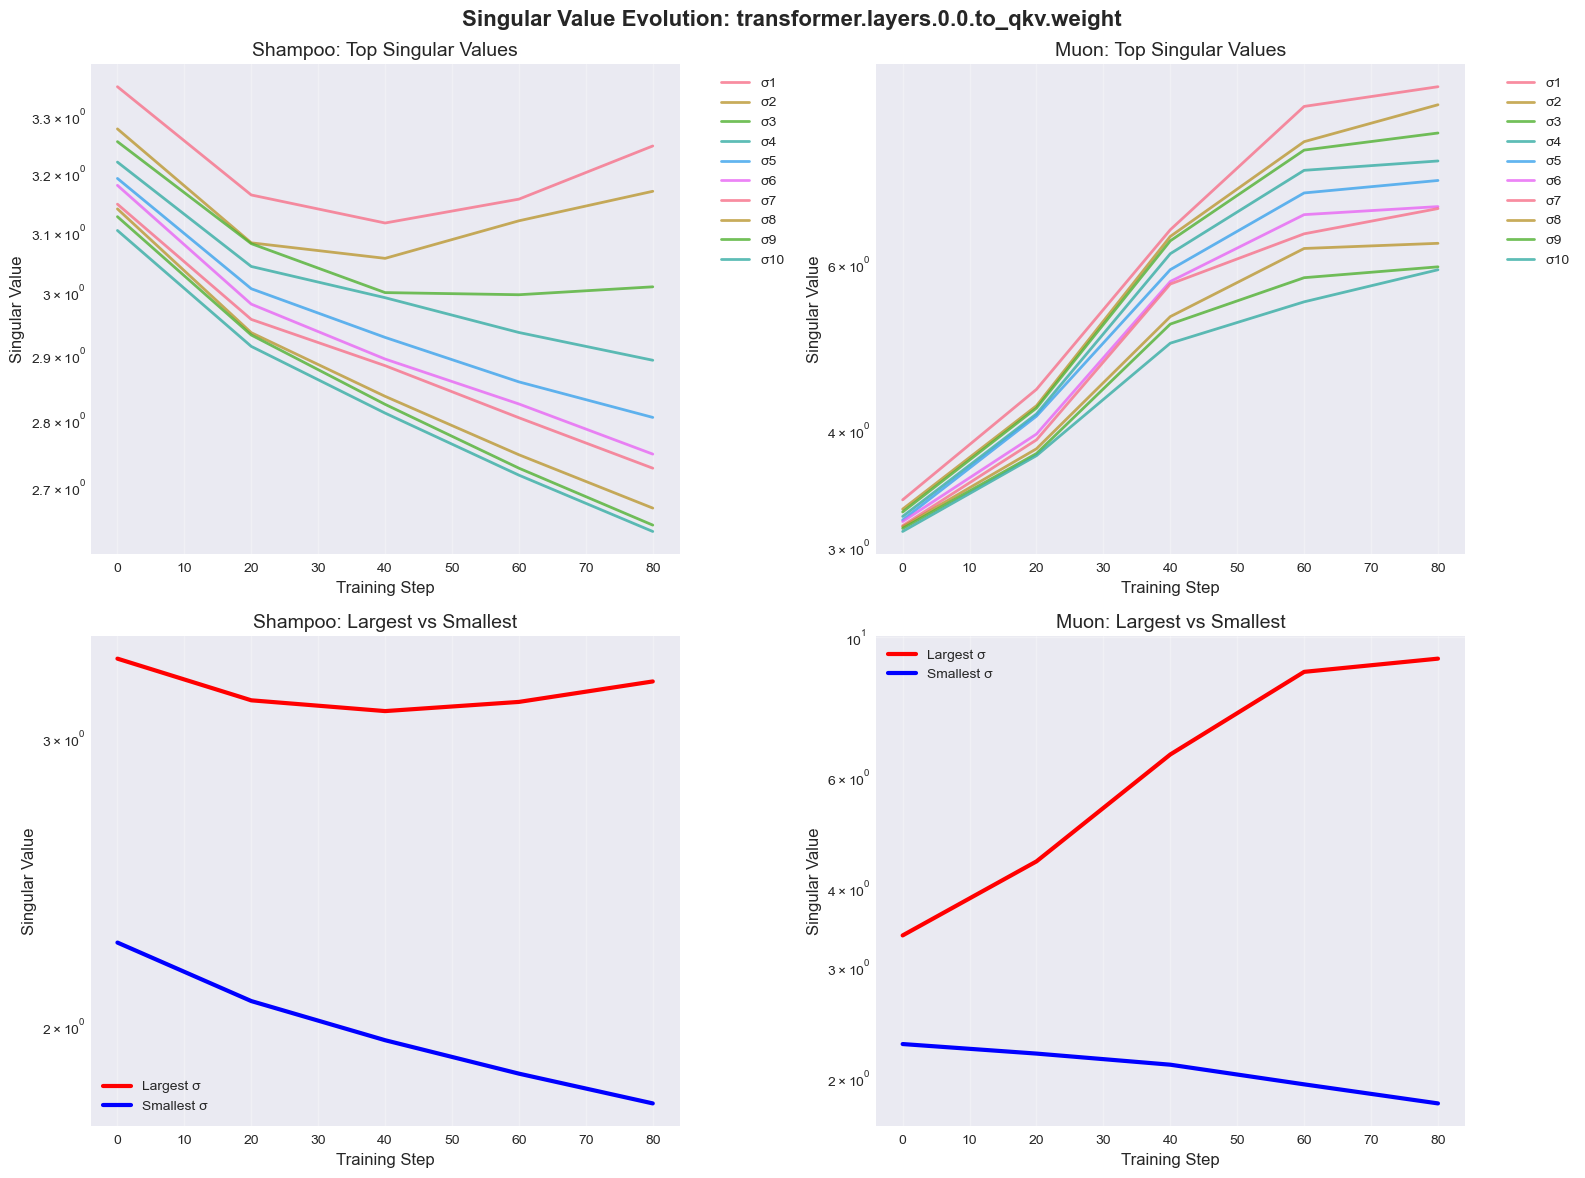

In [10]:
def plot_singular_value_evolution(data, layer_name=None, max_singular_values=10):
    """Plot evolution of singular values over training steps."""
    
    shampoo_sv = data.get('singular_values_shampoo', [])
    muon_sv = data.get('singular_values_muon', [])
    
    if not shampoo_sv or not muon_sv:
        print("No singular value data available")
        return
    
    # Get available layers
    available_layers = list(shampoo_sv[0][1].keys())
    
    if layer_name is None:
        layer_name = available_layers[0]  # Use first layer
    
    if layer_name not in available_layers:
        print(f"Layer '{layer_name}' not found. Available layers: {available_layers}")
        return
    
    # Extract data for the specified layer
    shampoo_steps = [step for step, _ in shampoo_sv]
    shampoo_svs = [sv_dict[layer_name] for _, sv_dict in shampoo_sv]
    
    print(shampoo_steps)
    muon_steps = [step for step, _ in muon_sv]
    muon_svs = [sv_dict[layer_name] for _, sv_dict in muon_sv]
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Singular Value Evolution: {layer_name}', fontsize=16, fontweight='bold')
    
    # Plot top singular values
    ax1 = axes[0, 0]
    for i in range(min(max_singular_values, len(shampoo_svs[0]))):
        shampoo_top_i = [sv[i] for sv in shampoo_svs]
        ax1.plot(shampoo_steps, shampoo_top_i, label=f'σ{i+1}', alpha=0.8, linewidth=2)
    ax1.set_title('Shampoo: Top Singular Values')
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Singular Value')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')
    
    ax2 = axes[0, 1]
    for i in range(min(max_singular_values, len(muon_svs[0]))):
        muon_top_i = [sv[i] for sv in muon_svs]
        ax2.plot(muon_steps, muon_top_i, label=f'σ{i+1}', alpha=0.8, linewidth=2)
    ax2.set_title('Muon: Top Singular Values')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Singular Value')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    # Plot largest vs smallest singular values
    ax3 = axes[1, 0]
    shampoo_largest = [sv[0] for sv in shampoo_svs]
    shampoo_smallest = [sv[-1] for sv in shampoo_svs]
    ax3.plot(shampoo_steps, shampoo_largest, label='Largest σ', linewidth=3, color='red')
    ax3.plot(shampoo_steps, shampoo_smallest, label='Smallest σ', linewidth=3, color='blue')
    ax3.set_title('Shampoo: Largest vs Smallest')
    ax3.set_xlabel('Training Step')
    ax3.set_ylabel('Singular Value')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_yscale('log')
    
    ax4 = axes[1, 1]
    muon_largest = [sv[0] for sv in muon_svs]
    muon_smallest = [sv[-1] for sv in muon_svs]
    ax4.plot(muon_steps, muon_largest, label='Largest σ', linewidth=3, color='red')
    ax4.plot(muon_steps, muon_smallest, label='Smallest σ', linewidth=3, color='blue')
    ax4.set_title('Muon: Largest vs Smallest')
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('Singular Value')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')
    
    plt.tight_layout()
    plt.show()

# Plot for the first available layer
if 'singular_values_shampoo' in data and data['singular_values_shampoo']:
    available_layers = list(data['singular_values_shampoo'][0][1].keys())
    print(f"Available layers: {available_layers}")
    plot_singular_value_evolution(data, layer_name=available_layers[0])


In [9]:
shampoo_steps

NameError: name 'shampoo_steps' is not defined

## 2. Singular Value Distribution Comparison


## 2.5 Combined Singular Value Histograms (All Layers)


Saved combined histogram plot to: singular_value_histograms_combined.png


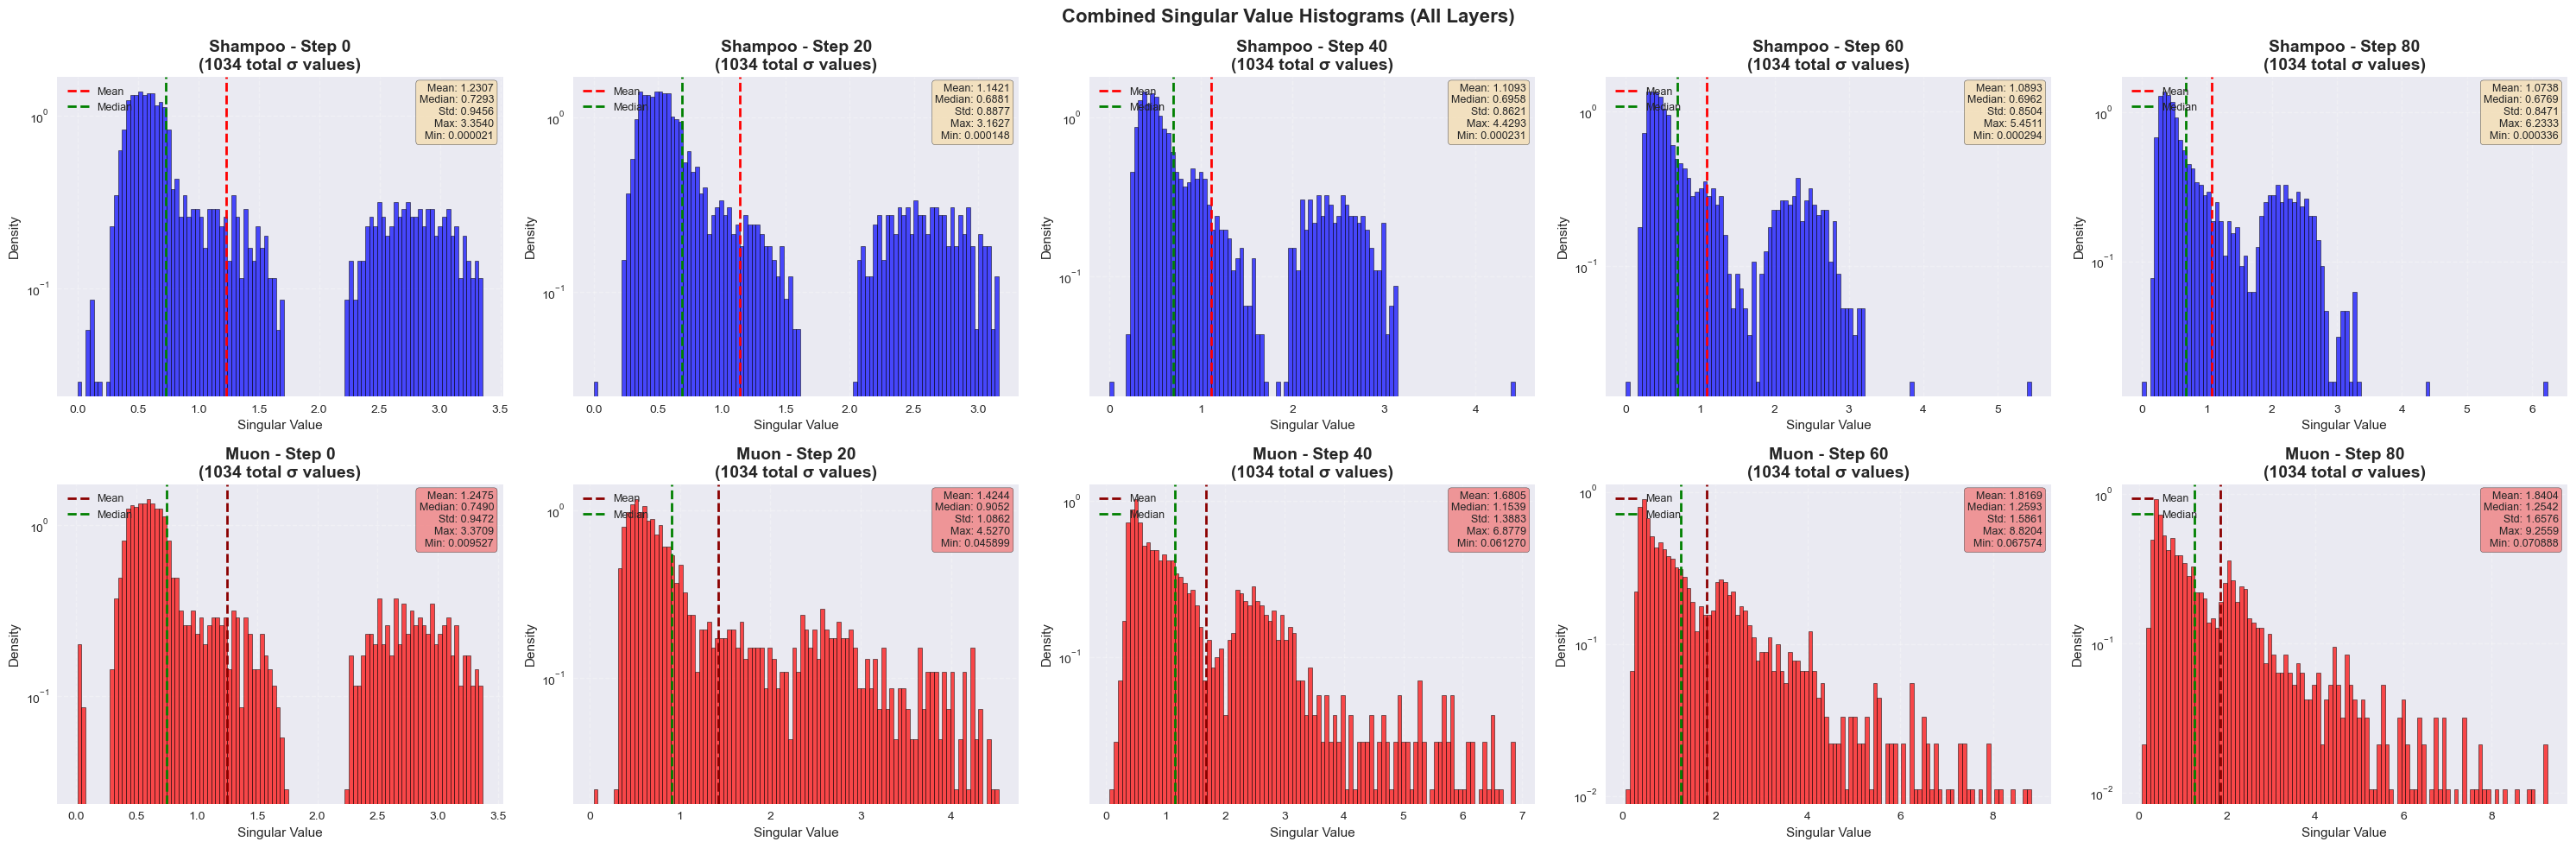

SINGULAR VALUE DISTRIBUTION COMPARISON (ALL LAYERS COMBINED)

Step 0:
  Shampoo: mean=1.2307, median=0.7293, std=0.9456
  Muon:    mean=1.2475, median=0.7490, std=0.9472
  Ratio (Shampoo/Muon) - mean: 0.987, median: 0.974

Step 20:
  Shampoo: mean=1.1421, median=0.6881, std=0.8877
  Muon:    mean=1.4244, median=0.9052, std=1.0862
  Ratio (Shampoo/Muon) - mean: 0.802, median: 0.760

Step 40:
  Shampoo: mean=1.1093, median=0.6958, std=0.8621
  Muon:    mean=1.6805, median=1.1539, std=1.3883
  Ratio (Shampoo/Muon) - mean: 0.660, median: 0.603

Step 60:
  Shampoo: mean=1.0893, median=0.6962, std=0.8504
  Muon:    mean=1.8169, median=1.2593, std=1.5861
  Ratio (Shampoo/Muon) - mean: 0.600, median: 0.553

Step 80:
  Shampoo: mean=1.0738, median=0.6769, std=0.8471
  Muon:    mean=1.8404, median=1.2542, std=1.6576
  Ratio (Shampoo/Muon) - mean: 0.583, median: 0.540


In [13]:
def plot_combined_singular_value_histograms(data, num_steps_to_plot=None):
    """
    Plot histograms of ALL singular values combined across all layers for each optimizer.
    
    Args:
        data: Dictionary containing singular value data
        num_steps_to_plot: Number of steps to plot (None = all steps). Can be int or list of indices.
    """
    
    shampoo_sv = data.get('singular_values_shampoo', [])
    muon_sv = data.get('singular_values_muon', [])
    
    if not shampoo_sv or not muon_sv:
        print("No singular value data available")
        return
    
    # Determine which steps to plot
    if num_steps_to_plot is None:
        # Plot all steps
        step_indices = range(len(shampoo_sv))
    elif isinstance(num_steps_to_plot, int):
        # Plot last N steps
        step_indices = range(max(0, len(shampoo_sv) - num_steps_to_plot), len(shampoo_sv))
    else:
        # Plot specific indices
        step_indices = num_steps_to_plot
    
    num_plots = len(step_indices)
    
    # Create subplots - 2 rows (Shampoo and Muon), columns for each step
    fig, axes = plt.subplots(2, num_plots, figsize=(6*num_plots, 10))
    if num_plots == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle('Combined Singular Value Histograms (All Layers)', fontsize=16, fontweight='bold')
    
    for idx, step_idx in enumerate(step_indices):
        shampoo_step, shampoo_sv_dict = shampoo_sv[step_idx]
        muon_step, muon_sv_dict = muon_sv[step_idx]
        
        # Combine all singular values across all layers
        shampoo_all_svs = np.concatenate([svs for svs in shampoo_sv_dict.values()])
        muon_all_svs = np.concatenate([svs for svs in muon_sv_dict.values()])
        
        # Plot Shampoo histogram
        ax_shampoo = axes[0, idx]
        n, bins, patches = ax_shampoo.hist(shampoo_all_svs, bins=100, alpha=0.7, color='blue', 
                                           density=True, edgecolor='black', linewidth=0.5)
        ax_shampoo.set_title(f'Shampoo - Step {shampoo_step}\n({len(shampoo_all_svs)} total σ values)', 
                            fontweight='bold')
        ax_shampoo.set_xlabel('Singular Value', fontsize=11)
        ax_shampoo.set_ylabel('Density', fontsize=11)
        ax_shampoo.set_yscale('log')
        ax_shampoo.grid(True, alpha=0.3, linestyle='--')
        
        # Add statistics
        shampoo_mean = np.mean(shampoo_all_svs)
        shampoo_median = np.median(shampoo_all_svs)
        shampoo_std = np.std(shampoo_all_svs)
        shampoo_max = np.max(shampoo_all_svs)
        shampoo_min = np.min(shampoo_all_svs)
        
        stats_text = f'Mean: {shampoo_mean:.4f}\nMedian: {shampoo_median:.4f}\nStd: {shampoo_std:.4f}\nMax: {shampoo_max:.4f}\nMin: {shampoo_min:.6f}'
        ax_shampoo.text(0.98, 0.98, stats_text, transform=ax_shampoo.transAxes,
                       verticalalignment='top', horizontalalignment='right',
                       bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
                       fontsize=9)
        
        # Add vertical lines for mean and median
        ax_shampoo.axvline(shampoo_mean, color='red', linestyle='--', linewidth=2, label=f'Mean')
        ax_shampoo.axvline(shampoo_median, color='green', linestyle='--', linewidth=2, label=f'Median')
        ax_shampoo.legend(loc='upper left', fontsize=9)
        
        # Plot Muon histogram
        ax_muon = axes[1, idx]
        n, bins, patches = ax_muon.hist(muon_all_svs, bins=100, alpha=0.7, color='red', 
                                        density=True, edgecolor='black', linewidth=0.5)
        ax_muon.set_title(f'Muon - Step {muon_step}\n({len(muon_all_svs)} total σ values)', 
                         fontweight='bold')
        ax_muon.set_xlabel('Singular Value', fontsize=11)
        ax_muon.set_ylabel('Density', fontsize=11)
        ax_muon.set_yscale('log')
        ax_muon.grid(True, alpha=0.3, linestyle='--')
        
        # Add statistics
        muon_mean = np.mean(muon_all_svs)
        muon_median = np.median(muon_all_svs)
        muon_std = np.std(muon_all_svs)
        muon_max = np.max(muon_all_svs)
        muon_min = np.min(muon_all_svs)
        
        stats_text = f'Mean: {muon_mean:.4f}\nMedian: {muon_median:.4f}\nStd: {muon_std:.4f}\nMax: {muon_max:.4f}\nMin: {muon_min:.6f}'
        ax_muon.text(0.98, 0.98, stats_text, transform=ax_muon.transAxes,
                    verticalalignment='top', horizontalalignment='right',
                    bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.8),
                    fontsize=9)
        
        # Add vertical lines for mean and median
        ax_muon.axvline(muon_mean, color='darkred', linestyle='--', linewidth=2, label=f'Mean')
        ax_muon.axvline(muon_median, color='green', linestyle='--', linewidth=2, label=f'Median')
        ax_muon.legend(loc='upper left', fontsize=9)
    
    # Save the plot
    plot_filename = 'singular_value_histograms_combined.png'
    plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
    print(f"Saved combined histogram plot to: {plot_filename}")
    plt.tight_layout()
    plt.show()
    
    # Print comparison summary
    print("=" * 80)
    print("SINGULAR VALUE DISTRIBUTION COMPARISON (ALL LAYERS COMBINED)")
    print("=" * 80)
    for idx, step_idx in enumerate(step_indices):
        shampoo_step, shampoo_sv_dict = shampoo_sv[step_idx]
        muon_step, muon_sv_dict = muon_sv[step_idx]
        
        shampoo_all_svs = np.concatenate([svs for svs in shampoo_sv_dict.values()])
        muon_all_svs = np.concatenate([svs for svs in muon_sv_dict.values()])
        
        print(f"\nStep {shampoo_step}:")
        print(f"  Shampoo: mean={np.mean(shampoo_all_svs):.4f}, median={np.median(shampoo_all_svs):.4f}, std={np.std(shampoo_all_svs):.4f}")
        print(f"  Muon:    mean={np.mean(muon_all_svs):.4f}, median={np.median(muon_all_svs):.4f}, std={np.std(muon_all_svs):.4f}")
        print(f"  Ratio (Shampoo/Muon) - mean: {np.mean(shampoo_all_svs)/np.mean(muon_all_svs):.3f}, median: {np.median(shampoo_all_svs)/np.median(muon_all_svs):.3f}")
    print("=" * 80)

# Plot combined histograms for all available steps
plot_combined_singular_value_histograms(data)


In [ ]:
# Alternative: Plot with overlaid histograms for direct comparison
def plot_overlaid_singular_value_histograms(data, num_steps_to_plot=None):
    """
    Plot overlaid histograms of singular values for direct Shampoo vs Muon comparison.
    
    Args:
        data: Dictionary containing singular value data
        num_steps_to_plot: Number of steps to plot (None = all steps). Can be int or list of indices.
    """
    
    shampoo_sv = data.get('singular_values_shampoo', [])
    muon_sv = data.get('singular_values_muon', [])
    
    if not shampoo_sv or not muon_sv:
        print("No singular value data available")
        return
    
    # Determine which steps to plot
    if num_steps_to_plot is None:
        step_indices = range(len(shampoo_sv))
    elif isinstance(num_steps_to_plot, int):
        step_indices = range(max(0, len(shampoo_sv) - num_steps_to_plot), len(shampoo_sv))
    else:
        step_indices = num_steps_to_plot
    
    num_plots = len(step_indices)
    
    # Create figure with subplots
    ncols = min(3, num_plots)  # Max 3 columns
    nrows = (num_plots + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(7*ncols, 5*nrows))
    if num_plots == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    fig.suptitle('Overlaid Singular Value Histograms: Shampoo vs Muon (All Layers)', 
                 fontsize=16, fontweight='bold')
    
    for idx, step_idx in enumerate(step_indices):
        shampoo_step, shampoo_sv_dict = shampoo_sv[step_idx]
        muon_step, muon_sv_dict = muon_sv[step_idx]
        
        # Combine all singular values across all layers
        shampoo_all_svs = np.concatenate([svs for svs in shampoo_sv_dict.values()])
        muon_all_svs = np.concatenate([svs for svs in muon_sv_dict.values()])
        
        ax = axes[idx]
        
        # Plot both histograms overlaid
        ax.hist(shampoo_all_svs, bins=100, alpha=0.6, color='blue', 
                density=True, label=f'Shampoo (n={len(shampoo_all_svs)})', 
                edgecolor='darkblue', linewidth=0.5)
        ax.hist(muon_all_svs, bins=100, alpha=0.6, color='red', 
                density=True, label=f'Muon (n={len(muon_all_svs)})', 
                edgecolor='darkred', linewidth=0.5)
        
        ax.set_title(f'Step {shampoo_step}', fontweight='bold', fontsize=12)
        ax.set_xlabel('Singular Value', fontsize=10)
        ax.set_ylabel('Density', fontsize=10)
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper right', fontsize=9)
        
        # Add mean lines
        shampoo_mean = np.mean(shampoo_all_svs)
        muon_mean = np.mean(muon_all_svs)
        ax.axvline(shampoo_mean, color='blue', linestyle='--', linewidth=2, alpha=0.8)
        ax.axvline(muon_mean, color='red', linestyle='--', linewidth=2, alpha=0.8)
        
        # Add statistics box
        stats_text = f'Shampoo: μ={shampoo_mean:.4f}\nMuon: μ={muon_mean:.4f}\nRatio: {shampoo_mean/muon_mean:.3f}'
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               verticalalignment='top', horizontalalignment='left',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='gray'),
               fontsize=8)
    
    # Hide unused subplots
    for idx in range(num_plots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.show()

# Plot overlaid histograms - you can specify which steps to plot
# Examples:
# plot_overlaid_singular_value_histograms(data)  # All steps
# plot_overlaid_singular_value_histograms(data, num_steps_to_plot=3)  # Last 3 steps
# plot_overlaid_singular_value_histograms(data, num_steps_to_plot=[0, -1])  # First and last steps

plot_overlaid_singular_value_histograms(data)  # Plot all steps overlaid


Comparing distributions at step 80 (Shampoo) vs 80 (Muon)


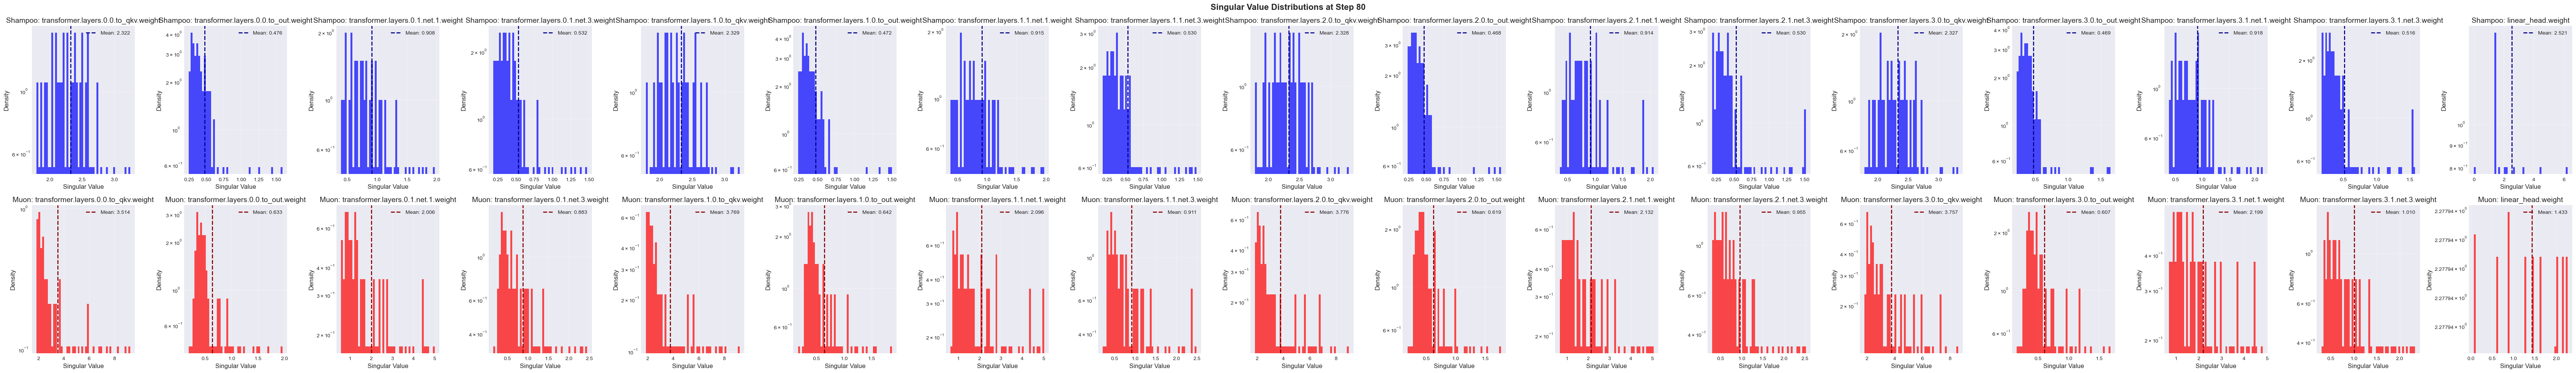

In [7]:
def plot_singular_value_distributions(data, step_idx=-1):
    """Plot singular value distributions at a specific step."""
    
    shampoo_sv = data.get('singular_values_shampoo', [])
    muon_sv = data.get('singular_values_muon', [])
    
    if not shampoo_sv or not muon_sv:
        print("No singular value data available")
        return
    
    # Use the last step by default
    shampoo_step, shampoo_sv_dict = shampoo_sv[step_idx]
    muon_step, muon_sv_dict = muon_sv[step_idx]
    
    print(f"Comparing distributions at step {shampoo_step} (Shampoo) vs {muon_step} (Muon)")
    
    # Get all layers
    layers = list(shampoo_sv_dict.keys())
    n_layers = len(layers)
    
    # Create subplots
    fig, axes = plt.subplots(2, n_layers, figsize=(4*n_layers, 10))
    if n_layers == 1:
        axes = axes.reshape(2, 1)
    
    fig.suptitle(f'Singular Value Distributions at Step {shampoo_step}', fontsize=16, fontweight='bold')
    
    for i, layer_name in enumerate(layers):
        shampoo_svs = shampoo_sv_dict[layer_name]
        muon_svs = muon_sv_dict[layer_name]
        
        # Shampoo distribution
        ax1 = axes[0, i]
        ax1.hist(shampoo_svs, bins=50, alpha=0.7, color='blue', density=True)
        ax1.set_title(f'Shampoo: {layer_name}')
        ax1.set_xlabel('Singular Value')
        ax1.set_ylabel('Density')
        ax1.set_yscale('log')
        ax1.grid(True, alpha=0.3)
        
        # Muon distribution
        ax2 = axes[1, i]
        ax2.hist(muon_svs, bins=50, alpha=0.7, color='red', density=True)
        ax2.set_title(f'Muon: {layer_name}')
        ax2.set_xlabel('Singular Value')
        ax2.set_ylabel('Density')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)
        
        # Add statistics
        shampoo_mean = np.mean(shampoo_svs)
        shampoo_std = np.std(shampoo_svs)
        muon_mean = np.mean(muon_svs)
        muon_std = np.std(muon_svs)
        
        ax1.axvline(shampoo_mean, color='darkblue', linestyle='--', linewidth=2, label=f'Mean: {shampoo_mean:.3f}')
        ax2.axvline(muon_mean, color='darkred', linestyle='--', linewidth=2, label=f'Mean: {muon_mean:.3f}')
        
        ax1.legend()
        ax2.legend()
    
    plt.tight_layout()
    plt.show()

plot_singular_value_distributions(data)


## 3. Singular Value Ratio Analysis


In [ ]:
def plot_singular_value_ratios(data):
    """Plot singular value ratios (condition number, effective rank, etc.)."""
    
    shampoo_sv = data.get('singular_values_shampoo', [])
    muon_sv = data.get('singular_values_muon', [])
    
    if not shampoo_sv or not muon_sv:
        print("No singular value data available")
        return
    
    # Extract steps
    shampoo_steps = [step for step, _ in shampoo_sv]
    muon_steps = [step for step, _ in muon_sv]
    
    # Get layers
    layers = list(shampoo_sv[0][1].keys())
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Singular Value Ratio Analysis', fontsize=16, fontweight='bold')
    
    # Condition number (largest/smallest)
    ax1 = axes[0, 0]
    for layer_name in layers:
        shampoo_cond = []
        muon_cond = []
        
        for _, sv_dict in shampoo_sv:
            svs = sv_dict[layer_name]
            cond = svs[0] / svs[-1] if svs[-1] > 0 else np.inf
            shampoo_cond.append(cond)
        
        for _, sv_dict in muon_sv:
            svs = sv_dict[layer_name]
            cond = svs[0] / svs[-1] if svs[-1] > 0 else np.inf
            muon_cond.append(cond)
        
        ax1.plot(shampoo_steps, shampoo_cond, label=f'Shampoo: {layer_name}', linewidth=2)
        ax1.plot(muon_steps, muon_cond, '--', label=f'Muon: {layer_name}', linewidth=2)
    
    ax1.set_title('Condition Number (σ₁/σₙ)')
    ax1.set_xlabel('Training Step')
    ax1.set_ylabel('Condition Number')
    ax1.set_yscale('log')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Effective rank (sum of squares / largest squared)
    ax2 = axes[0, 1]
    for layer_name in layers:
        shampoo_eff_rank = []
        muon_eff_rank = []
        
        for _, sv_dict in shampoo_sv:
            svs = sv_dict[layer_name]
            eff_rank = np.sum(svs**2) / (svs[0]**2) if svs[0] > 0 else 0
            shampoo_eff_rank.append(eff_rank)
        
        for _, sv_dict in muon_sv:
            svs = sv_dict[layer_name]
            eff_rank = np.sum(svs**2) / (svs[0]**2) if svs[0] > 0 else 0
            muon_eff_rank.append(eff_rank)
        
        ax2.plot(shampoo_steps, shampoo_eff_rank, label=f'Shampoo: {layer_name}', linewidth=2)
        ax2.plot(muon_steps, muon_eff_rank, '--', label=f'Muon: {layer_name}', linewidth=2)
    
    ax2.set_title('Effective Rank')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Effective Rank')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Ratio of top 5 to total
    ax3 = axes[1, 0]
    for layer_name in layers:
        shampoo_top5_ratio = []
        muon_top5_ratio = []
        
        for _, sv_dict in shampoo_sv:
            svs = sv_dict[layer_name]
            top5_sum = np.sum(svs[:5]**2)
            total_sum = np.sum(svs**2)
            ratio = top5_sum / total_sum if total_sum > 0 else 0
            shampoo_top5_ratio.append(ratio)
        
        for _, sv_dict in muon_sv:
            svs = sv_dict[layer_name]
            top5_sum = np.sum(svs[:5]**2)
            total_sum = np.sum(svs**2)
            ratio = top5_sum / total_sum if total_sum > 0 else 0
            muon_top5_ratio.append(ratio)
        
        ax3.plot(shampoo_steps, shampoo_top5_ratio, label=f'Shampoo: {layer_name}', linewidth=2)
        ax3.plot(muon_steps, muon_top5_ratio, '--', label=f'Muon: {layer_name}', linewidth=2)
    
    ax3.set_title('Top 5 Singular Values Energy Ratio')
    ax3.set_xlabel('Training Step')
    ax3.set_ylabel('Energy Ratio')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Decay rate (exponential fit)
    ax4 = axes[1, 1]
    for layer_name in layers:
        shampoo_decay = []
        muon_decay = []
        
        for _, sv_dict in shampoo_sv:
            svs = sv_dict[layer_name]
            # Fit exponential decay to singular values
            if len(svs) > 1:
                x = np.arange(len(svs))
                log_svs = np.log(svs + 1e-10)
                coeffs = np.polyfit(x, log_svs, 1)
                decay_rate = -coeffs[0]  # Negative of slope
                shampoo_decay.append(decay_rate)
            else:
                shampoo_decay.append(0)
        
        for _, sv_dict in muon_sv:
            svs = sv_dict[layer_name]
            if len(svs) > 1:
                x = np.arange(len(svs))
                log_svs = np.log(svs + 1e-10)
                coeffs = np.polyfit(x, log_svs, 1)
                decay_rate = -coeffs[0]
                muon_decay.append(decay_rate)
            else:
                muon_decay.append(0)
        
        ax4.plot(shampoo_steps, shampoo_decay, label=f'Shampoo: {layer_name}', linewidth=2)
        ax4.plot(muon_steps, muon_decay, '--', label=f'Muon: {layer_name}', linewidth=2)
    
    ax4.set_title('Singular Value Decay Rate')
    ax4.set_xlabel('Training Step')
    ax4.set_ylabel('Decay Rate')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_singular_value_ratios(data)


## 4. Training Metrics vs Singular Values


In [ ]:
def plot_metrics_vs_singular_values(data):
    """Plot training metrics alongside singular value statistics."""
    
    shampoo_sv = data.get('singular_values_shampoo', [])
    muon_sv = data.get('singular_values_muon', [])
    shampoo_metrics = data.get('metrics_shampoo', [])
    muon_metrics = data.get('metrics_muon', [])
    
    if not shampoo_sv or not muon_sv or not shampoo_metrics.size or not muon_metrics.size:
        print("Insufficient data for metrics vs singular values plot")
        return
    
    # Convert metrics to numpy arrays
    shampoo_metrics = np.array(shampoo_metrics)
    muon_metrics = np.array(muon_metrics)
    
    # Extract epochs and accuracies
    shampoo_epochs = shampoo_metrics[:, 0]
    shampoo_test_acc = shampoo_metrics[:, 4]
    muon_epochs = muon_metrics[:, 0]
    muon_test_acc = muon_metrics[:, 4]
    
    # Get singular value steps and compute statistics
    shampoo_sv_steps = [step for step, _ in shampoo_sv]
    muon_sv_steps = [step for step, _ in muon_sv]
    
    # Compute average condition number across layers
    shampoo_avg_cond = []
    muon_avg_cond = []
    
    for _, sv_dict in shampoo_sv:
        layer_conds = []
        for layer_name, svs in sv_dict.items():
            cond = svs[0] / svs[-1] if svs[-1] > 0 else np.inf
            layer_conds.append(cond)
        shampoo_avg_cond.append(np.mean(layer_conds))
    
    for _, sv_dict in muon_sv:
        layer_conds = []
        for layer_name, svs in sv_dict.items():
            cond = svs[0] / svs[-1] if svs[-1] > 0 else np.inf
            layer_conds.append(cond)
        muon_avg_cond.append(np.mean(layer_conds))
    
    # Create figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle('Training Metrics vs Singular Value Statistics', fontsize=16, fontweight='bold')
    
    # Test accuracy over epochs
    ax1 = axes[0, 0]
    ax1.plot(shampoo_epochs, shampoo_test_acc, label='Shampoo', linewidth=3, color='blue')
    ax1.plot(muon_epochs, muon_test_acc, label='Muon', linewidth=3, color='red')
    ax1.set_title('Test Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Test Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Average condition number over steps
    ax2 = axes[0, 1]
    ax2.plot(shampoo_sv_steps, shampoo_avg_cond, label='Shampoo', linewidth=3, color='blue')
    ax2.plot(muon_sv_steps, muon_avg_cond, label='Muon', linewidth=3, color='red')
    ax2.set_title('Average Condition Number')
    ax2.set_xlabel('Training Step')
    ax2.set_ylabel('Condition Number')
    ax2.set_yscale('log')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Correlation plot
    ax3 = axes[1, 0]
    # Interpolate condition numbers to match epoch times
    shampoo_cond_interp = np.interp(shampoo_epochs, shampoo_sv_steps, shampoo_avg_cond)
    muon_cond_interp = np.interp(muon_epochs, muon_sv_steps, muon_avg_cond)
    
    ax3.scatter(shampoo_cond_interp, shampoo_test_acc, label='Shampoo', alpha=0.7, s=50)
    ax3.scatter(muon_cond_interp, muon_test_acc, label='Muon', alpha=0.7, s=50)
    ax3.set_title('Test Accuracy vs Condition Number')
    ax3.set_xlabel('Condition Number')
    ax3.set_ylabel('Test Accuracy')
    ax3.set_xscale('log')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Final comparison
    ax4 = axes[1, 1]
    final_shampoo_acc = shampoo_test_acc[-1]
    final_muon_acc = muon_test_acc[-1]
    final_shampoo_cond = shampoo_avg_cond[-1]
    final_muon_cond = muon_avg_cond[-1]
    
    x = ['Shampoo', 'Muon']
    acc_values = [final_shampoo_acc, final_muon_acc]
    cond_values = [final_shampoo_cond, final_muon_cond]
    
    ax4_twin = ax4.twinx()
    
    bars1 = ax4.bar(x, acc_values, alpha=0.7, color=['blue', 'red'], label='Test Accuracy')
    bars2 = ax4_twin.bar(x, cond_values, alpha=0.7, color=['lightblue', 'lightcoral'], label='Condition Number')
    
    ax4.set_title('Final Performance Comparison')
    ax4.set_ylabel('Test Accuracy')
    ax4_twin.set_ylabel('Condition Number')
    ax4_twin.set_yscale('log')
    
    # Add value labels on bars
    for bar, val in zip(bars1, acc_values):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.3f}', ha='center', va='bottom')
    
    for bar, val in zip(bars2, cond_values):
        ax4_twin.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.1, 
                     f'{val:.1e}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

plot_metrics_vs_singular_values(data)


## 5. Summary Statistics


In [ ]:
def print_summary_statistics(data):
    """Print comprehensive summary statistics."""
    
    shampoo_sv = data.get('singular_values_shampoo', [])
    muon_sv = data.get('singular_values_muon', [])
    shampoo_metrics = data.get('metrics_shampoo', [])
    muon_metrics = data.get('metrics_muon', [])
    
    print("=" * 80)
    print("SUMMARY STATISTICS")
    print("=" * 80)
    
    if shampoo_sv and muon_sv:
        # Get final singular values
        final_shampoo_sv = shampoo_sv[-1][1]
        final_muon_sv = muon_sv[-1][1]
        
        print("\nFINAL SINGULAR VALUE STATISTICS:")
        print("-" * 50)
        
        for layer_name in final_shampoo_sv.keys():
            shampoo_svs = final_shampoo_sv[layer_name]
            muon_svs = final_muon_sv[layer_name]
            
            print(f"\nLayer: {layer_name}")
            print(f"  Shampoo:")
            print(f"    - Largest σ: {shampoo_svs[0]:.6f}")
            print(f"    - Smallest σ: {shampoo_svs[-1]:.6f}")
            print(f"    - Condition #: {shampoo_svs[0]/shampoo_svs[-1]:.2e}")
            print(f"    - Mean σ: {np.mean(shampoo_svs):.6f}")
            print(f"    - Std σ: {np.std(shampoo_svs):.6f}")
            print(f"    - Effective rank: {np.sum(shampoo_svs**2)/(shampoo_svs[0]**2):.2f}")
            
            print(f"  Muon:")
            print(f"    - Largest σ: {muon_svs[0]:.6f}")
            print(f"    - Smallest σ: {muon_svs[-1]:.6f}")
            print(f"    - Condition #: {muon_svs[0]/muon_svs[-1]:.2e}")
            print(f"    - Mean σ: {np.mean(muon_svs):.6f}")
            print(f"    - Std σ: {np.std(muon_svs):.6f}")
            print(f"    - Effective rank: {np.sum(muon_svs**2)/(muon_svs[0]**2):.2f}")
            
            # Comparison
            cond_ratio = (shampoo_svs[0]/shampoo_svs[-1]) / (muon_svs[0]/muon_svs[-1])
            print(f"  Comparison:")
            print(f"    - Condition # ratio (Shampoo/Muon): {cond_ratio:.2f}")
    
    if shampoo_metrics.size and muon_metrics.size:
        shampoo_metrics = np.array(shampoo_metrics)
        muon_metrics = np.array(muon_metrics)
        
        print("\n\nFINAL TRAINING METRICS:")
        print("-" * 50)
        print(f"Shampoo final test accuracy: {shampoo_metrics[-1, 4]:.4f}")
        print(f"Muon final test accuracy: {muon_metrics[-1, 4]:.4f}")
        print(f"Difference (Shampoo - Muon): {shampoo_metrics[-1, 4] - muon_metrics[-1, 4]:+.4f}")
        
        print(f"\nShampoo final train accuracy: {shampoo_metrics[-1, 2]:.4f}")
        print(f"Muon final train accuracy: {muon_metrics[-1, 2]:.4f}")
        print(f"Difference (Shampoo - Muon): {shampoo_metrics[-1, 2] - muon_metrics[-1, 2]:+.4f}")
    
    print("\n" + "=" * 80)

print_summary_statistics(data)


## Usage Instructions

1. **Run the dual training experiment** first using `main_dual_training.py`
2. **Execute this notebook** to visualize the results
3. **Modify the analysis** by uncommenting interactive sections
4. **Export results** by uncommenting the export function

### Key Insights to Look For:

- **Condition Number**: Lower condition numbers indicate better-conditioned weight matrices
- **Effective Rank**: Higher effective rank suggests better utilization of the parameter space
- **Singular Value Decay**: Steeper decay may indicate better regularization
- **Distribution Shape**: Different optimizers may produce different singular value distributions
- **Correlation with Performance**: How singular value statistics correlate with test accuracy

### Expected File Structure:
```
logs/
└── dual_training_<uuid>/
    ├── singular_values_shampoo.pkl
    ├── singular_values_muon.pkl
    ├── metrics_shampoo.npy
    ├── metrics_muon.npy
    ├── config.pt
    ├── model_shampoo.pt
    └── model_muon.pt
```
